# Style Transfer

In [0]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-jdggwjlz
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-jdggwjlz
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=c2d87ead4dacf4c926f71159259881ae92422c05213dd7a093b283573fa6508a
  Stored in directory: /tmp/pip-ephem-wheel-cache-3an7wxtv/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
from coutils import rel_error
from collections import namedtuple
import matplotlib.pyplot as plt

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225])

%matplotlib inline

In [0]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
dtype = torch.cuda.FloatTensor 

Good to go!


In [0]:
!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
!unzip a4_styles.zip && rm a4_styles.zip

--2020-02-01 11:55:28--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/a4_styles.zip
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2170872 (2.1M) [application/zip]
Saving to: ‘a4_styles.zip’

a4_styles.zip       100%[===================>]   2.07M  2.91MB/s    in 0.7s    

2020-02-01 11:55:29 (2.91 MB/s) - ‘a4_styles.zip’ saved [2170872/2170872]

Archive:  a4_styles.zip
   creating: styles/
  inflating: styles/tubingen.jpg     
  inflating: styles/the_scream.jpg   
  inflating: styles/starry_night.jpg  
  inflating: styles/muse.jpg         
  inflating: styles/composition_vii.jpg  
  inflating: style-transfer-checks.npz  


In [0]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

answers = dict(np.load('style-transfer-checks.npz'))

In [0]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

#please disregard warnings about initialization

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4.74M/4.74M [00:00<00:00, 7.16MB/s]


In [0]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    ##############################################################################
    # TODO: Compute the content loss for style transfer.                         #
    ##############################################################################
    # Replace "pass" statement with your code
    loss = content_weight * torch.sum((content_current - content_original) ** 2)
    return loss
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [0]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer])

    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(torch.from_numpy(answers['cl_out']).type(dtype))

Maximum error is 0.000


In [0]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    ##############################################################################
    # TODO: Compute the Gram matrix from features.                               #
    ##############################################################################
    # Replace "pass" statement with your code
    N, C, H, W = features.shape
    features = features.flatten(start_dim=2)
    gram = torch.bmm(features, features.transpose(1, 2))
    if normalize:
        gram = gram / (H * W * C)
    return gram
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [0]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    student_output = gram_matrix(feats[5].clone())
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(torch.from_numpy(answers['gm_out']).type(dtype))

Maximum error is 0.000


In [0]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    ##############################################################################
    # TODO: Computes the style loss at a set of layers.                          #
    # Hint: you can do this with one for loop over the style layers, and should  #
    # not be very much code (~5 lines).                                          #
    # You will need to use your gram_matrix function.                            #
    ##############################################################################
    # Replace "pass" statement with your code
    style_loss = 0
    for i, layer in enumerate(style_layers):
        gram = gram_matrix(feats[layer])
        loss = style_weights[i] * torch.sum((gram - style_targets[i]) ** 2)
        style_loss += loss
    return style_loss
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [0]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights)
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

    
style_loss_test(torch.from_numpy(answers['sl_out']).type(dtype))

Error is 0.000


In [0]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    ##############################################################################
    # TODO: Compute total variation loss.                                        #
    # Your implementation should be vectorized and not require any loops!        #
    ##############################################################################
    # Replace "pass" statement with your code
    term1 = torch.sum((img[:, :, 1:] - img[:, :, :-1]) ** 2)
    term2 = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    loss = tv_weight * (term1 + term2)
    return loss
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

In [0]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight)
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(torch.from_numpy(answers['tv_out']).type(dtype))

Error is 0.000


In [0]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

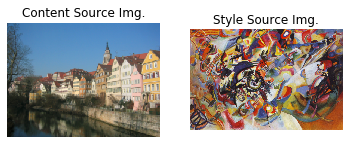

Iteration 0


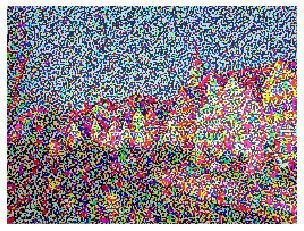

Iteration 100


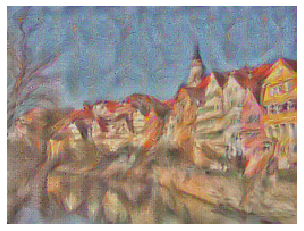

Iteration 199


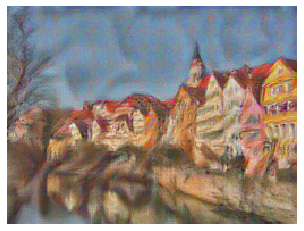

In [0]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

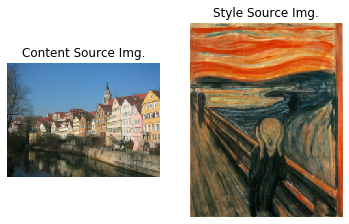

Iteration 0


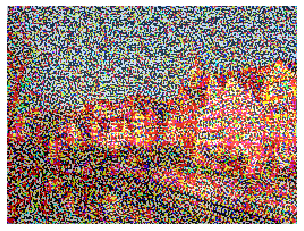

Iteration 100


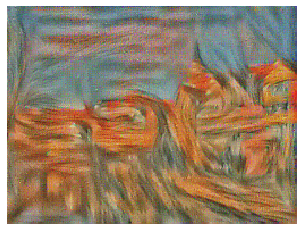

Iteration 199


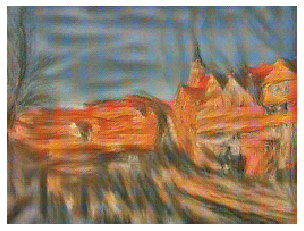

In [0]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

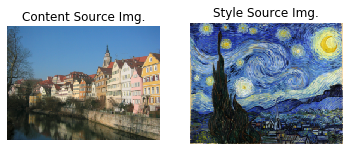

Iteration 0


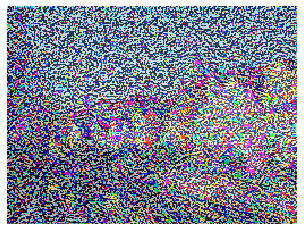

Iteration 100


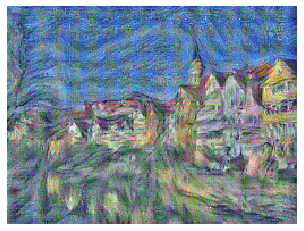

Iteration 199


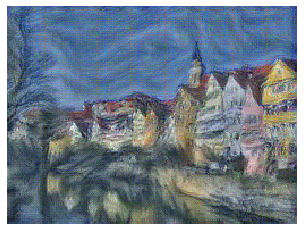

In [0]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion

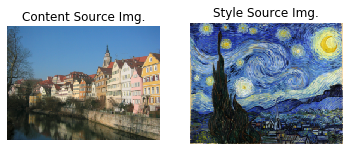

Iteration 0


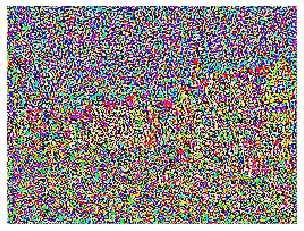

Iteration 100


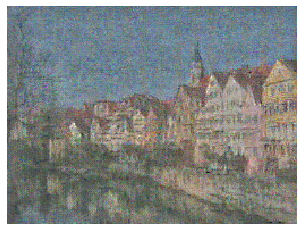

Iteration 199


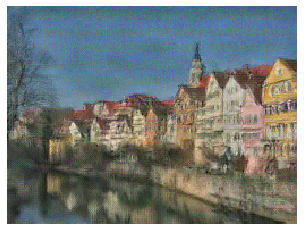

In [0]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)